# Topic Modeling with [BERTopic](https://arxiv.org/abs/2203.05794)  
[Tutorial](https://www.youtube.com/watch?v=aDWB3u2ihy0&t=1s)  
[Site](https://maartengr.github.io/BERTopic/index.html)  
Within this notebook, we will undertake the implementation of the first module of the project, named **"Aspect Classifier"**.

Import required packages

In [1]:
import os
import json
import wandb
import logging
import numpy as np
import pandas as pd
from rich import print
# embedding models

from sentence_transformers import SentenceTransformer

# dimentionality reduction
from umap import UMAP
import umap.plot as umap_plotter

# clustering
from hdbscan import HDBSCAN

# word count vectorization
import nltk
# nltk.download('stopwords')
from pyarabic.araby import strip_tashkeel
import arabicstopwords.arabicstopwords as stp
from sklearn.feature_extraction.text import TfidfVectorizer

# topics words representation
from bertopic.representation import KeyBERTInspired

# topic modeling
from bertopic import BERTopic

# visualizations
import io
import matplotlib.image as mpimg

# environment variables
from dotenv import find_dotenv, load_dotenv

/home/elshehawy/anaconda3/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
_ = load_dotenv(find_dotenv())

In [3]:
data_path = '../../data/processed/porcessed_data.json'

with open(data_path, 'r') as f:
    data = json.load(f)

In [4]:
for col_name in data.keys():
    print(col_name)
    print(data[col_name][:5])

add_suggestions

[
    'تغيير الدكتوره',
    'ترابط مخرجات القيادة الفعال مع تنفيذ برامج الأمن السيبراني',
    'لازيوجد',
    'إضافة مواضيع أكثر عن أمن الويب',
    'إضافة case study لأحد الشركات المحلية'
]

like

[
    'المقرر بشكل عام',
    'طريقة الشرح',
    'عضو التدريس ومحتوى المقرر',
    'تطوير مهارات القيادة',
    'المعلومات المخصصة في تاسيس برنامج الأمن السيبراني'
]

dislike

[
    'عدم تعاون الدكتوره ودرجتي النهائية',
    'المواضيع نحتاج زيادة في عددها',
    'المواضيع عامة، تخصيصها أكثر في قيادة الأمن السيبراني بتكون أفضل',
    'المعمل ممتاز لكن نبغى نروح أبعد من ذلك',
    'لاشي كل شي كان رائع'
]

improve_course

[
    'تعديل متطلبات اجتياز المقرر وتوزيع الدرجات بشكل أفضل',
    'ربط المنهج بشكل مباشر مع البرنامج',
    'إضافة مواضيع تخص اختبارات أمن الويب والتولز المستخدمه حاليا في معطم الشركات',
    'تخصيص شباتر أكثر في قيادة الأمن السيبراني',
    'الجانب العملي يحتاج تطوير أكثر لكن اجمالا ممتاز'
]

In [5]:
# wandb configs
PROJECT_NAME = "TOPIC_MODELING_FOR_SURVEYS"
JOB_TYPE = "BERTopic"
params = {}

In [6]:
# logger file
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    level=logging.INFO,
    filename="../../data/logs.txt",
)

In [7]:
logger = logging.getLogger(__name__)

In [8]:
wandb_login = os.environ['WANDB_KEY']
wandb.login(key=wandb_login)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find BERTopic.ipynb.
wandb: Currently logged in as: elshehawy. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
# fix random state
random_state = 42

In [10]:
text = []
for k, v in data.items():
    text.extend( v)

text = sorted(set(text))
print(len(text))

1610

In [11]:
text[:5]

['- dr. emad is a professional in everything (explaining, organizing, supporting, [رابط])-this course is improved my skills',
 '- إعطاء مشاريع صغيرة بدلا من مشروع كبير-يكون الغرض التركيز على إكساب الطلبة المهارات الأساسية نظرا لعدم دراسة هذه المادة سابقا في البكالوريس',
 '- التركيز على إعطاء الطلبة خلفية جيدة عن تعلم الالة بشكل واضح وبسيط وتوقعانهم أول مرة يدرسوها',
 '- عمل منهج واضح بالنسبة للطلاب ومحدد-إيضاح طريقة التقييم-دمج محتوى المنهج مع ما ناخذه كطلاب علوم حاسبات في المواد الأخرى',
 '1-the verity of tools that we used and applied 2-knowing how to access aziz in data processing 3-having 3 presentations during the semester about the the topic that i am focusing on was improved my presenting skills. 4-[رابط] was so cooperative in term of specifying the dates and deadlines for our work and presentations.']

In [12]:
text2 = []
for k, v in data.items():
    text2.extend([(k, t) for t in v])

text2 = sorted(text2, key=lambda x: x[1])    

In [13]:
len(text), len(text2)

(1610, 1701)

In [14]:
text_df = pd.DataFrame(text2, columns=['column', 'text'])
text_df = text_df.drop_duplicates(subset=['text'])

In [15]:
len(text_df)

1610

In [16]:
text_df.tail()

column                                               text
1696  add_suggestions  يوجد غموض كبير في مقرر المادة من قبل الدكتور ف...
1697             like             يوفر تاسيس جيد بالنسبة للمستوى الميتدأ
1698             like  يوفر كل ما يحتاجه الباحث من أجل عمل محاكاة بصو...
1699             like                                  يوفر معرفة ممتازه
1700   improve_course                            يومين في الأسبوع أو يوم

In [17]:
assert text == text_df['text'].tolist()

In [18]:
params['data'] = {'data_size': len(text)}

In [19]:
params

{'data': {'data_size': 1610}}

# Embeddings

In [37]:
model_path = 'sentence-transformers/use-cmlm-multilingual'
# model_path = 'lanwuwei/GigaBERT-v4-Arabic-and-English'
embedding_model = SentenceTransformer(model_path)

Some weights of the model checkpoint at sentence-transformers/use-cmlm-multilingual were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
device = 'cpu'
text_embeddings = embedding_model.encode(text, device=device, show_progress_bar=True)

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

In [39]:
print(text_embeddings.shape)

(1610, 768)

In [40]:
params['embedding_model'] = {}

In [41]:
params["embedding_model"] = {"type": embedding_model.__class__.__name__}

In [42]:
params['embedding_model']['name'] = model_path.split('/')[-1]

# Dimensionality Reduction

In [43]:
# min_dist = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 0.15, 0.2]
# n_neighbors = [3]

# for n in n_neighbors:
#     for dist in min_dist:
#         mapper = UMAP(n_neighbors=n, n_components=2, min_dist=dist, metric="euclidean", random_state=random_state).fit(text_embeddings)
#         umap_plotter.points(mapper)

In [44]:
n_neighbors = 8
n_components = 8 
min_dist = 0.0
metric = "euclidean"

reduction_model = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric,
    random_state=random_state,
    low_memory=True,
)

In [45]:
params["reduction_model"] = {"type": reduction_model.__class__.__name__}
params["reduction_model"]["params"] = reduction_model.get_params()

# Clustering

In [46]:
# if a cluster contains lower than min_cluster_size elements, it will be considered noise
min_clustersize = 16
# The larger the value, the more points will be declared as noise, 
# and clusters will be restricted to progressively more dense areas.
min_samples = 8
metric_cluster = "euclidean"
cluster_selection_method = "eom"
prediction_data = True
single_cluster = False

clustering_model = HDBSCAN(
    min_cluster_size=min_clustersize,
    metric=metric_cluster,
    cluster_selection_method=cluster_selection_method,
    allow_single_cluster=single_cluster,
    prediction_data=prediction_data,
    min_samples=min_samples,
)

In [47]:
params["clustering_model"] = {"type": clustering_model.__class__.__name__}
params["clustering_model"]["params"] = clustering_model.get_params()

# Vectorizer

In [48]:
ar_stop_words = stp.stopwords_list()
extra_stop_words = [
    "السلام",
    "عليكم",
    "ورحمة",
    "الله",
    "وبركاته",
    "ورحمه",
    "رحمة",
    "رحمه",
    "بركاته",
    "بركاتة",
    "سلام",
    "جميل",
    "مفيد",
    "ممتاز",
    "جيد",
    "جدا",
    "ممتع",
    "سهل",
    "يتم",
    "مفيد",
    "مفيدة",
    "مفيده",
    "شكرا",
    "شكر",
    "تم",
    "شي",
    "شيء",
    "الشكر"
    "يوجد",
    "رائع",
    "كان",
    "يكون",
    "كانت",
    "تكون",
    "أسف",
    "اسف",
    "آسف",
    "للاسف",
    "للأسف",
]

ar_stop_words += extra_stop_words
ar_stop_words += nltk.corpus.stopwords.words("arabic")
ar_stop_words = [strip_tashkeel(w) for w in ar_stop_words]
ar_stop_words = list(np.unique(ar_stop_words))

en_stop_words = nltk.corpus.stopwords.words('english')
en_stop_words += [
    "good",
    "clear",
    "very",
    "great",
    "very good",
    "excellent"
    "bad",
    "very bad",
    "fair",
    "thanks",
    "thank you",
    "nothing",
    "everything",
    "no",
    "none",
    "excellent",
]

all_stop_words = en_stop_words + ar_stop_words

min_df = 2
analyzer = "word"
max_df = 0.5
ngram_range = (1, 3)
max_features = 256

vectorizer_model = TfidfVectorizer(
    min_df=min_df,
    stop_words=all_stop_words,
    max_df=max_df,
    ngram_range=ngram_range,
    analyzer=analyzer,
    max_features=max_features,
)

In [49]:
params["vectorizer_model"] = {"type": vectorizer_model.__class__.__name__}
params["vectorizer_model"]["params"] = vectorizer_model.get_params()
params["vectorizer_model"]["params"]["stop_words"] = (
    stp.__name__ + " - " + stp.__author__
)

# Topic Representer

In [50]:
keybert_model = KeyBERTInspired(top_n_words=10)

In [51]:
params["topics_representer"] = {
    "type": keybert_model.__class__.__name__,
    "params": keybert_model.get_params(),
}

### Image Converter

In [52]:
def convert_to_wandb_img(img, scale=1.0, format="png", engine="orca"):
    img = img.to_image(format=format, engine=engine, scale=scale)
    image_stream = io.BytesIO(np.frombuffer(img, dtype=np.uint8))
    return wandb.Image(mpimg.imread(image_stream, format=format))

# BERTopic Topic Modeling

In [53]:
topic_model = BERTopic(
    # pipeline models
    embedding_model=embedding_model,
    umap_model=reduction_model,
    hdbscan_model=clustering_model,
    vectorizer_model=vectorizer_model,
    representation_model={"KeyBERT": keybert_model},
    # hyperparameters
    top_n_words=10,
    verbose=True,
    calculate_probabilities=True,
    # nr_topics='auto'
)

In [55]:
RUN_NAME = f"COL_NAME_INCLUDED;{model_path.split('/')[-1]};[{n_neighbors}, {n_components}, {min_dist}, {metric}];[{min_clustersize}, {min_samples}, {cluster_selection_method}];[{len(text)}]-manual-reduction"
print(RUN_NAME)

COL_NAME_INCLUDED;use-cmlm-multilingual;[8, 8, 0.0, euclidean];[16, 8, eom];[1610]-manual-reduction

In [56]:
run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE, name=RUN_NAME, config=params)

In [57]:
preds, probs = topic_model.fit_transform(text, text_embeddings)

2024-06-12 17:57:31,339 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-12 17:57:35,765 - BERTopic - Dimensionality - Completed ✓
2024-06-12 17:57:35,765 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-12 17:57:35,841 - BERTopic - Cluster - Completed ✓
2024-06-12 17:57:35,845 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-12 17:57:44,306 - BERTopic - Representation - Completed ✓


In [58]:
ind = 1

print(text[ind])
print(preds[ind])

- إعطاء مشاريع صغيرة بدلا من مشروع كبير-يكون الغرض التركيز على إكساب الطلبة المهارات الأساسية نظرا لعدم دراسة هذه 
المادة سابقا في البكالوريس

9

In [59]:
# display info about each discovered topic
topics_info = topic_model.get_topic_info()
topics_info.head(10)

Topic  Count                                        Name  \
0     -1    411  -1_دكتور_course_دكتورة المادة_دكتور المادة   
1      0    147   0_الأمن_السيبراني_الأمن السيبراني_المخاطر   
2      1    116                    1_يوجد_اي_course_helpful   
3      2     98                 2_نهائي_الدرجات_علمية_طريقة   
4      3     74      3_المعلومات_كمية المعلومات_new_الجديدة   
5      4     70      4_التطبيق_التطبيق العملي_استخدام_تطبيق   
6      5     70                    5_وضوح_المهام_عادل_طريقة   
7      6     68                    6_أشكر_الدكتور_dr_course   
8      7     64                 7_مدرس_الطلاب_التدريس_أستاذ   
9      8     59            8_مقرر_المقرر المقرر_جميلة_ومفيد   

                                      Representation  \
0  [دكتور, course, دكتورة المادة, دكتور المادة, p...   
1  [الأمن, السيبراني, الأمن السيبراني, المخاطر, ا...   
2  [يوجد, اي, course, helpful, ملم, ومفيد, أمثلة,...   
3  [نهائي, الدرجات, علمية, طريقة, حل, الطلبه, الم...   
4  [المعلومات, كمية المعلومات, new, الجديدة, كمية...   
5  [التطبيق, التطبيق العملي, استخدام, تطبيق, برنا...   
6  [وضوح, المهام, عادل, طريقة, توزيع, تقييم, الوا...   
7  [أشكر, الدكتور, dr, course, الشرح, دكتورة, us,...   
8  [مدرس, الطلاب, التدريس, أستاذ, أستاذ المقرر, ع...   
9  [مقرر, المقرر المقرر, جميلة, ومفيد, بشكل عام, ...   

                                             KeyBERT  \
0  [دكتور المادة, دكتورة المادة, الأستاذ, المحاضر...   
1  [الأمن السيبراني, الأمن, التشفير, المخاطر, الس...   
2  [يوجد, وجود, اي, إضافة, ومفيد, انه, واضح, المح...   
3  [تدريس, دكتورة المادة, teacher, exam, الطالب, ...   
4  [كمية المعلومات, المعلومات, إيصال المعلومات, ا...   
5  [التطبيق العملي, تطبيق عملي, والتطبيق, التطبيق...   
6  [وضوح, توضيح, واضح, الشرح, شرح, خطة, متطلبات, ...   
7  [شرح الدكتور, للدكتور, الدكتور, دكتور المادة, ...   
8  [عضو هيئة التدريس, هيئة التدريس, أستاذ المقرر,...   
9  [جميلة, المقرر المقرر, ومفيد, مهم, النهائي, مق...   

                                 Representative_Docs  
0  [دكتور المادة كان جيدا في المادة و في المتابعة...  
1  [تخصيص شباتر أكثر في قيادة الأمن السيبراني, تع...  
2    [لا يوجد., لا يوجد فهو متكامل, لا يوجد شي معين]  
3  [المادة مفيدة وتتطرق لمفهم مهم وجديد على أغلب ...  
4  [التفاعل وكثره المعلومات المطروحه, حجم المعلوم...  
5  [التطبيق العملي ومواضيع المقرر, التطبيق العملي...  
6  [وضوح المقرر وسلاسته, وضوح المقرر, طريقة توزيع...  
7  [أشكر الدكتور محمد رمضان دكتور اكرمنا بتقديم ا...  
8  [عضو هيئة التدريس متمكن من المادة, ظلم عضو هيئ...  
9  [مقرر رائع, مقرر جميل ومعلومات كبيره, الله يسع...

In [60]:
print(f"Total number of topics: {len(topic_model.get_topic_info()) - 1}")

Total number of topics: 23

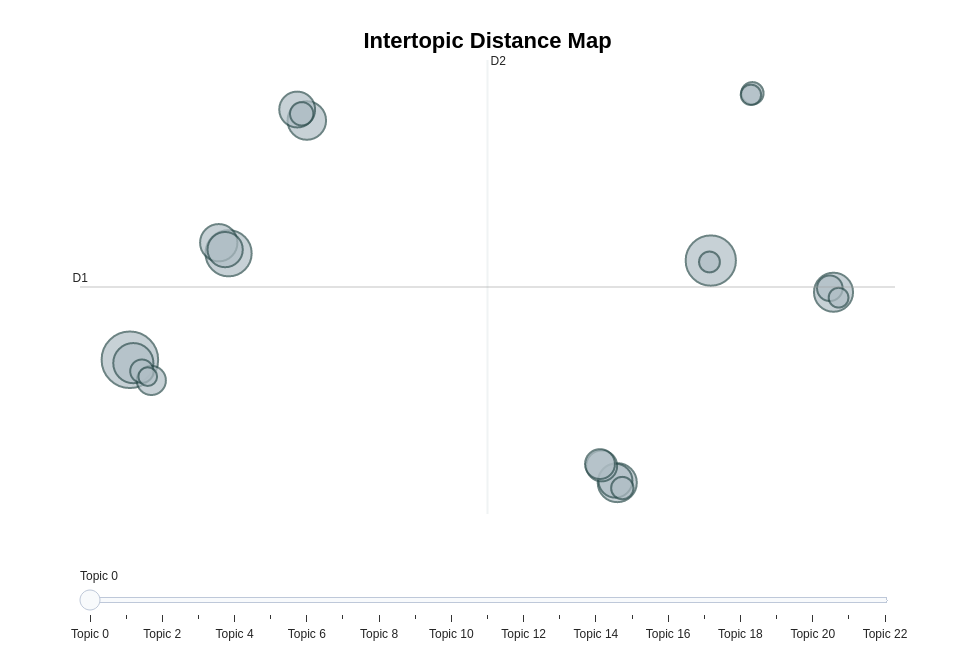

In [61]:
topic_model.visualize_topics()

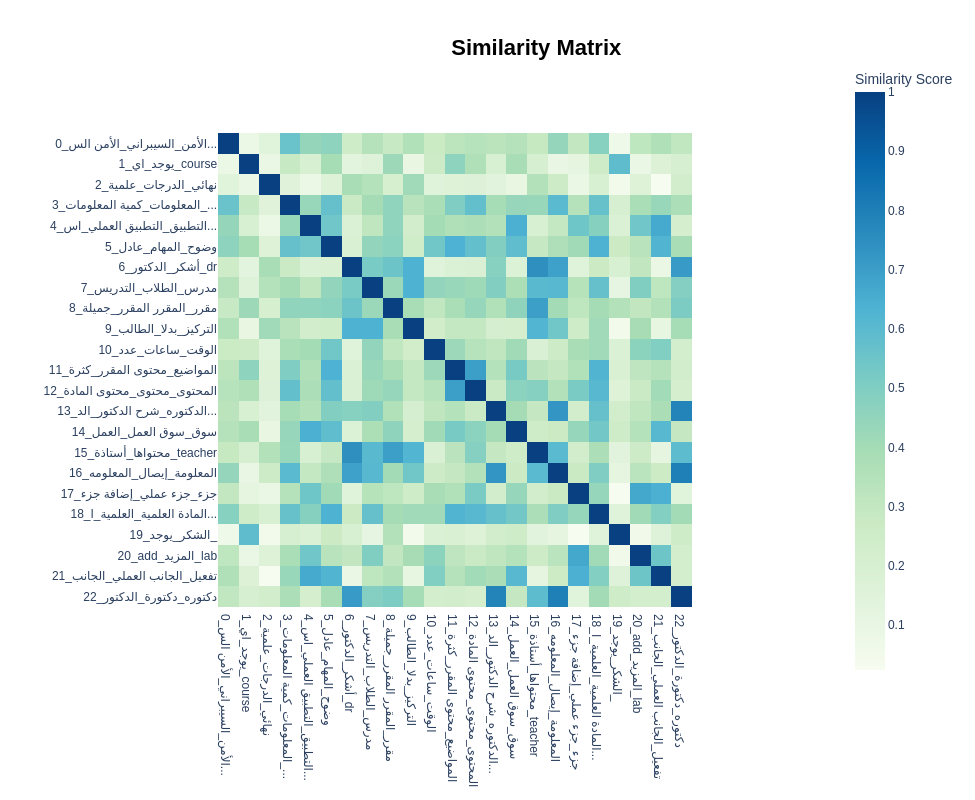

In [62]:
topic_model.visualize_heatmap()

100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 598.64it/s]


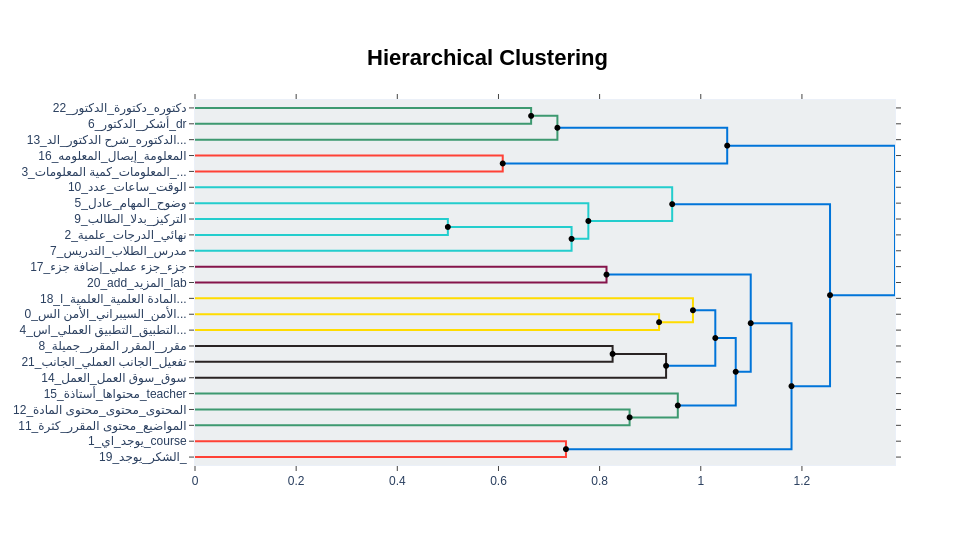

In [63]:
hierarchical_topics = topic_model.hierarchical_topics(text)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [64]:
def print_samples(i, preds, size=3):
    print(f'Topic ({i})')
    print('=='*22)
    inds = np.argwhere(np.array(preds) == i)
    print(f'Number of reviews about this topic: {len(inds)}')
    try:
        inds_ = np.random.choice(inds.squeeze(), size=size, replace=False)
    except:
        inds_ = np.random.choice(inds.squeeze(), size=3, replace=False)

    # print(np.array(text)[inds])
    selected_text = np.array(text)[inds_]
    
    for s, i in zip(selected_text, inds_):
        print(s, f'\nReview index {i}.')# Top {k} topics: {np.argsort(probs[i])[::-1][:k]}, with probability: {np.sort(probs[i])[::-1][:k]}', sep='\n') 
    
    return inds

In [65]:
_ = print_samples(18, preds, 5)

Topic (18)

============================================

Number of reviews about this topic: 23

تسلسل المادة العلمية للمقرر 
Review index 857.

احتكار المقرر على قراءة الأبحاث وتلخيصها 
Review index 367.

المادة العلمية المقدمة 
Review index 610.

ان يتم تطوير من مادة المقرر 
Review index 769.

تم إغلاق المكتبات الإلكترونية ولم نعد نستطيع استخدامها 
Review index 1002.

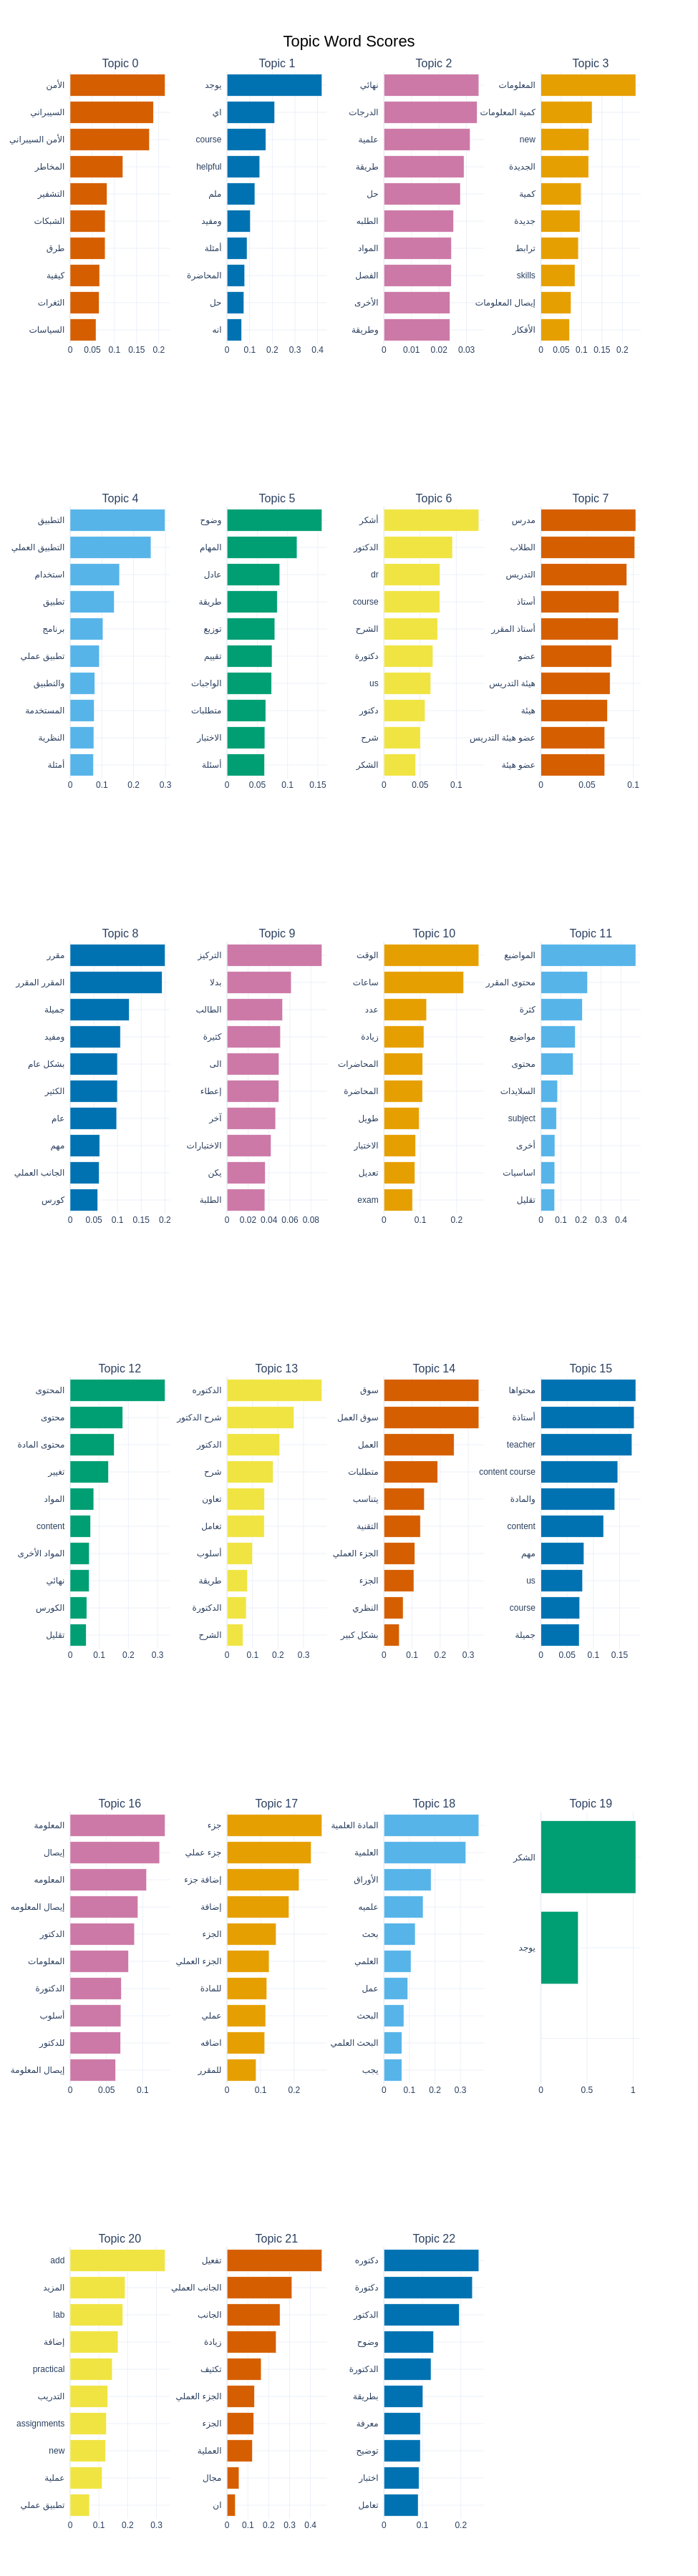

In [66]:
topic_model.visualize_barchart(
    width=280, height=600, n_words=20, top_n_topics=len(topics_info), 
)


# Topics Reduction


In [67]:
topics_to_merge = [
    [4, 17, 20, 21], # موازنة الجزء العملي مع الجزء النظري
    [6, 13, 15, 16, 22], # الدكتور
    
    # 0, and 3 are suggested by Dr. Reem
    [8, 12, 11, 0, 3], # محتوى المادة
    [1, 19], # None
]

# topics_to_merge = [[17, 15, 6, 0, 5]]

topic_model.merge_topics(text, topics_to_merge)

In [68]:
topics_info = topic_model.get_topic_info()
topics_info.head(10)

Topic  Count                                        Name  \
0     -1    411  -1_دكتور_دكتور المادة_دكتورة_دكتورة المادة   
1      0    365   0_الأمن_السيبراني_الأمن السيبراني_المخاطر   
2      1    173       1_الدكتور_الدكتوره_شرح الدكتور_دكتورة   
3      2    136                      2_يوجد_رابط_اي_helpful   
4      3    130            3_التطبيق_التطبيق العملي_add_جزء   
5      4     98                4_نهائي_الدرجات_علمية_المواد   
6      5     70                    5_وضوح_المهام_عادل_توزيع   
7      6     64                 6_الطلاب_مدرس_التدريس_أستاذ   
8      7     57             7_التركيز_الذكاء_الاصطناعي_بدلا   
9      8     53                     8_الوقت_ساعات_زيادة_عدد   

                                      Representation  \
0  [دكتور, دكتور المادة, دكتورة, دكتورة المادة, p...   
1  [الأمن, السيبراني, الأمن السيبراني, المخاطر, ا...   
2  [الدكتور, الدكتوره, شرح الدكتور, دكتورة, أشكر,...   
3  [يوجد, رابط, اي, helpful, الشكر, ومفيد, ملم, ع...   
4  [التطبيق, التطبيق العملي, add, جزء, تفعيل, جزء...   
5  [نهائي, الدرجات, علمية, المواد, وطريقة, دكتورة...   
6  [وضوح, المهام, عادل, توزيع, تقييم, كثرة, الموا...   
7  [الطلاب, مدرس, التدريس, أستاذ, أستاذ المقرر, ع...   
8  [التركيز, الذكاء, الاصطناعي, بدلا, الى, إعطاء,...   
9  [الوقت, ساعات, زيادة, عدد, المحاضرات, المحاضرة...   

                                             KeyBERT  \
0  [دكتور المادة, دكتورة المادة, الدكتوره, الأستا...   
1  [الأمن السيبراني, اساسيات الأمن, الأمن, securi...   
2  [شرح الدكتور, الدكتور, الدكتوره, للدكتور, الدك...   
3  [عدم وجود, يوجد, الشكر, ومفيد, اي, رابط, helpf...   
4  [التطبيق العملي, تطبيق عملي, والتطبيق, التطبيق...   
5  [دكتورة المادة, teacher, تدريس, subject, أستاذ...   
6  [وضوح, واضحة, واضح, الشرح, توضيح, خطة, التقييم...   
7  [عضو هيئة التدريس, هيئة التدريس, أستاذ المقرر,...   
8  [الذكاء, البحث العلمي, العلمي, للطالب, الطلاب,...   
9  [الوقت, ساعات, زيادة, تقليل, زياده, تحسين, تكث...   

                                 Representative_Docs  
0  [العملي وتواجدة في المحاضرات بشكل مكثف شرح وال...  
1  [تعلم والدخول في عالم الأمن السيبراني بالتفاصي...  
2  [الدكتور كان يشرح المنهج وكأنه فعلا يتحدث عن م...  
3  [لا يوجد كله ممتع, لا يوجد مرجع, لا يوجد عملي ...  
4  [التطبيق العملي لأداة fiar, التطبيق العملي ومو...  
5  [د. اعتماد من الدكاتره المحترمين لكن للاسف بنف...  
6  [وضوح المقرر وسلاسته, وضوح الكتاب المرجعي, طري...  
7  [عضو هيئة التدريس متمكن من المادة, ظلم عضو هيئ...  
8  [محاولة جذب الطلاب إلى هذا المقرر وتفعيل مسار ...  
9  [زيادة ساعات المقرر, زيادة الوقت المحدد على ال...

In [69]:
print(f"Total number of topics: {len(topics_info) - 1}")

Total number of topics: 11

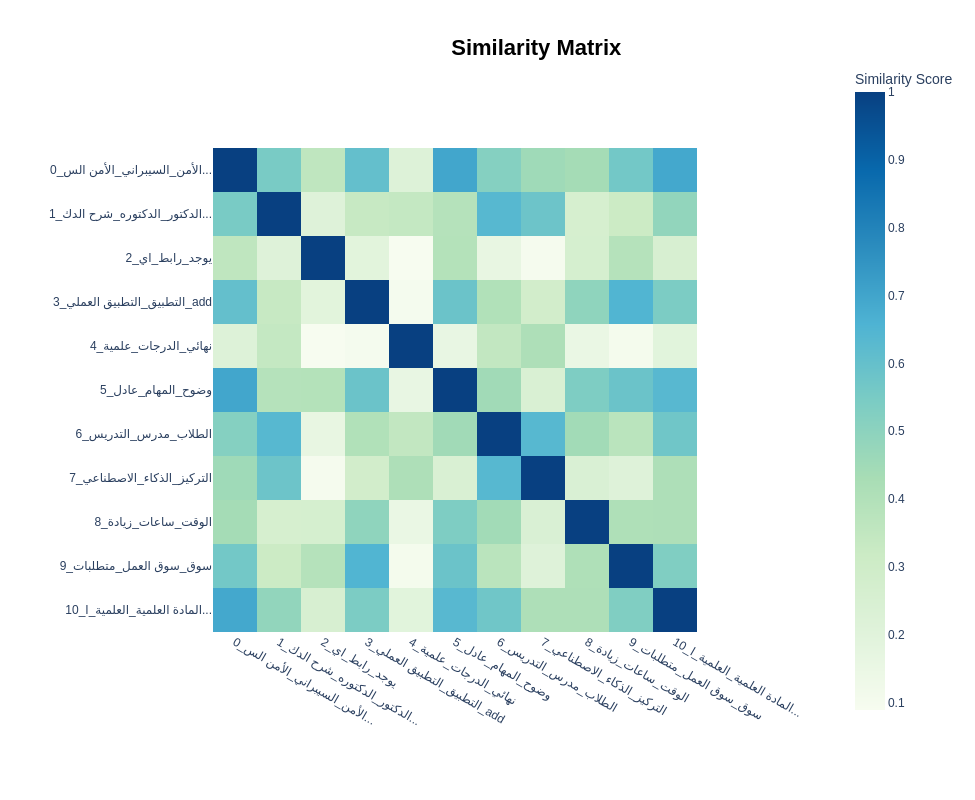

In [70]:
sim_matrix = topic_model.visualize_heatmap()
sim_matrix

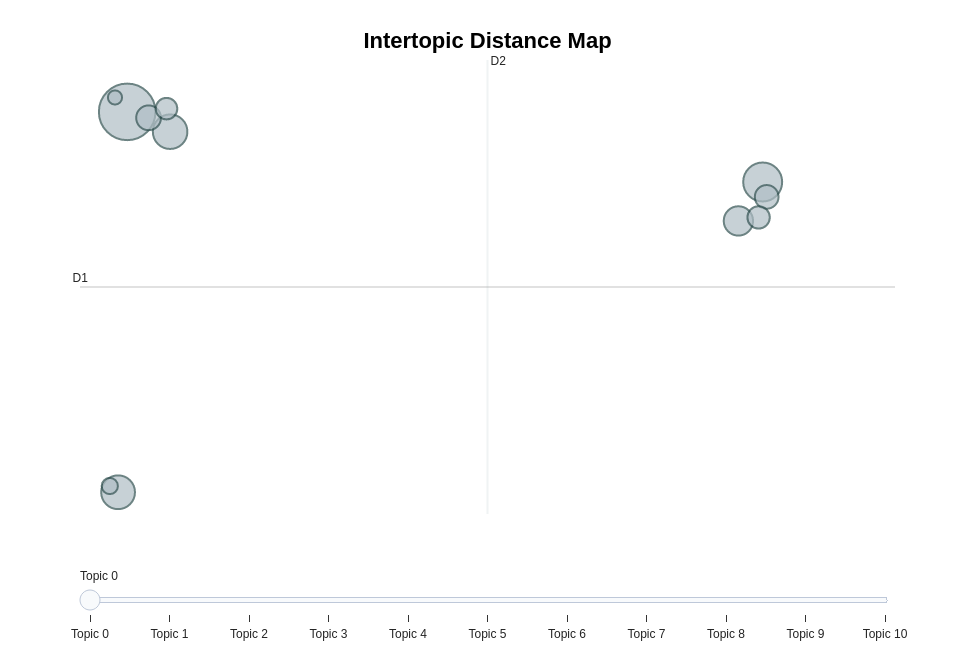

In [71]:
inter_distance = topic_model.visualize_topics()
inter_distance

100%|█████████████████████████████████████████████████████| 10/10 [00:00<00:00, 503.61it/s]


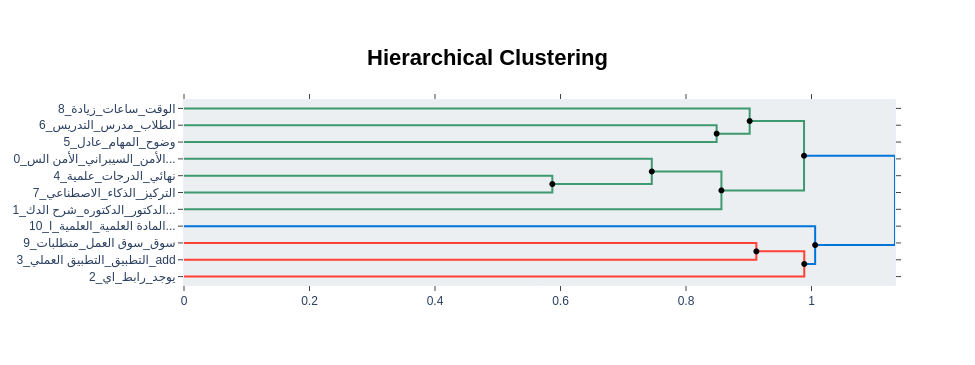

In [72]:
hierarchical_topics = topic_model.hierarchical_topics(text)
h_topics = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
h_topics

In [74]:
_ = print_samples(7, topic_model.topics_, 5)

Topic (7)

============================================

Number of reviews about this topic: 57

التركيز ع النمذجه والمحاكاه كاسلوب بحثي بدلا من التركيز ع الأسلوب الرياضي وان تتناسب الواجبات مع أهداف المقرر 
Review index 460.

كان شرح المادة بالانجليزي لوجود طالب غير عربي فلم يكن التفاعل بالمستوى المطلوب من قبلنا بمثل التفاعل في الكورسات 
العربية 
Review index 1295.

إضافة جزء عملي مهم جداا. لأن دراسة التشفير نظريا صعب نوعا ما ولكن مع التطبيق العملي راح تثبت المعلومة أكثر 
Review index 335.

مجال البحث وإعداده كان صعبا بحكم عدم المعرفة في المجال وكون البحث أعطي كتكليف كامل غير مجزأ 
Review index 1435.

طريقة التقييم مثل طلب واجبات بشكل مستمر على مدار الترم مما يزيد المعرفة أكثر من الاختبارات 
Review index 1217.

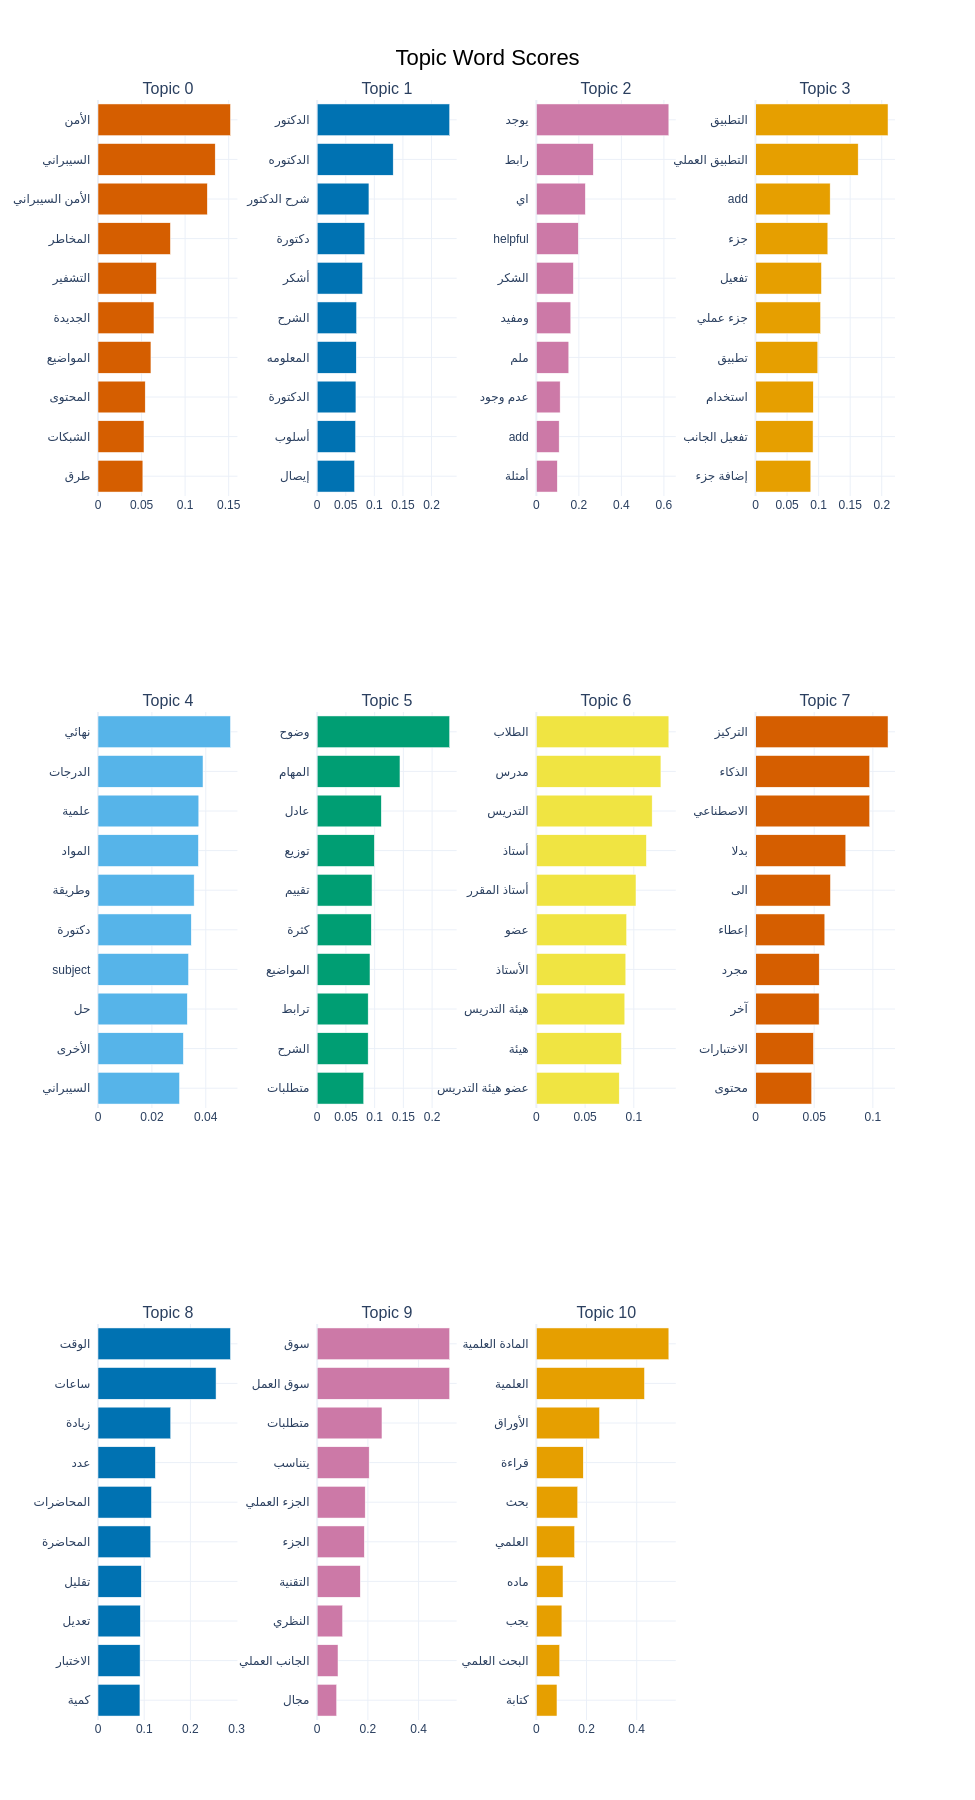

In [75]:
topic_words = topic_model.visualize_barchart(
    width=280, height=600, n_words=20, top_n_topics=len(topics_info), 
)
topic_words

In [79]:
strategy = 'probabilities'
new_topics = topic_model.reduce_outliers(text, topic_model.topics_, probabilities=topic_model.probabilities_, strategy=strategy, threshold=0.1)

In [80]:
print('Number of new outliers')
len([i for i in new_topics if i == -1])

Number of new outliers

53

In [81]:
metrics = {}
metrics["num_topics"] = len(topics_info) - 1
metrics["num_outliers"] = topics_info.Count[0]
metrics["num_outliers_reduced"] = len([i for i in new_topics if i == -1])
metrics["topics_info"] = wandb.Table(dataframe=topics_info)
metrics["intertopic_distance_map"] = convert_to_wandb_img(inter_distance)
metrics["similarity_matrix"] = convert_to_wandb_img(sim_matrix)
metrics["hierarchical_topics"] = convert_to_wandb_img(h_topics)
metrics["topic_word_scores"] = convert_to_wandb_img(topic_words)

[10121:0612/180138.089875:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [82]:
wandb.log(metrics)
wandb.finish()

# Saving Topic Labels

In [91]:
# df = pd.DataFrame()
text_df['topic_id'] = new_topics
# df['text'] = text
# df['topic_id'] = new_topics
# df['column'] = text_df['column']
df = text_df
df.head()

column                                               text  \
0             like  - dr. emad is a professional in everything (ex...   
1   improve_course  - إعطاء مشاريع صغيرة بدلا من مشروع كبير-يكون ا...   
2   improve_course  - التركيز على إعطاء الطلبة خلفية جيدة عن تعلم ...   
3  add_suggestions  - عمل منهج واضح بالنسبة للطلاب ومحدد-إيضاح طري...   
5             like  1-the verity of tools that we used and applied...   

   topic_id  
0         1  
1         7  
2         7  
3         4  
5         4

<Axes: >

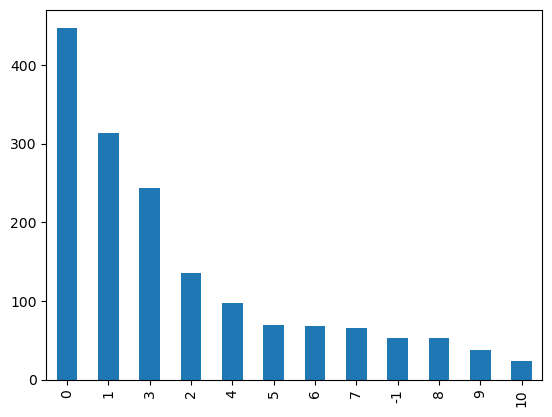

In [92]:
df['topic_id'].value_counts().plot(kind='bar')

In [93]:
save_path = '../../data/result/bertopic_labels-manual-reduction.csv'
df.to_csv(save_path, index=False)

In [94]:
_ = print_samples(7, new_topics, 5)

Topic (7)

============================================

Number of reviews about this topic: 66

المهام المطلوبة محفزة للتفكير والبحث الاختبارات كانت اوبن بوك ساعدنا بفهم المادة أكثر من مجرد حفظها 
Review index 723.

الوصول الى المستوى اللذي يستحقه طالب دراسات عليا في مرحلة دكتوراه لتوسيع منظور البحث والفكر لدى الطالب 
Review index 747.

المشاريع والاسايمنتات أتمنى ان تكون case study بدلا من سؤال عام وجواب بمعنى ان تكون تحليل لوضع راهن في شركان وما 
الى ذلك 
Review index 663.

يفضل وجود المشاريع بشكل أكثر لانها تعطينا خبره أفضل من وجود اختبارات 
Review index 1598.

كمية المعلومات النظرية الجانب العملي لهذه الماده ركيك ربما بسبب المصادر التي برسوم أو لان الكورس عن بعد اثر في ذلك 
Review index 1347.